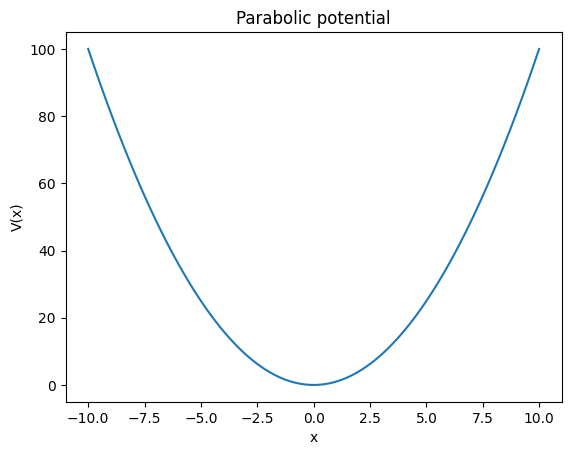

In [37]:
# define a parabolic potential and plot it

import numpy as np
import matplotlib.pyplot as plt

def parabolic_potential(x, a, b, c):
    return a * x**2 + b * x + c

def parabolic_gradient(x, a, b, c):
    return 2 * a * x + b

x = np.linspace(-10, 10, 100)
y = parabolic_potential(x, 1, 0, 0)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Parabolic potential')
plt.show()

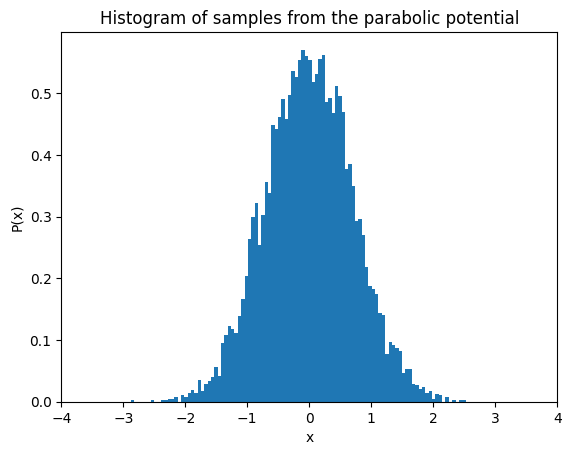

In [38]:
# sample from the distribution, by drawing a random point between -1 and 1
# and then accepting it with probability exp(-V(x))
samples_x = np.random.uniform(-10, 10, 100000)
samples_y = parabolic_potential(samples_x, 1, 0, 0)
samples_acceptance = np.exp(-samples_y)
samples_accepted = samples_x[np.random.uniform(0, 1, 100000) < samples_acceptance]
plt.hist(samples_accepted, bins=100, density=True)
plt.xlabel('x')
plt.ylabel('P(x)')
plt.xlim(-4, 4)
plt.title('Histogram of samples from the parabolic potential')
plt.show()

  0%|          | 0/10000000 [00:00<?, ?it/s]

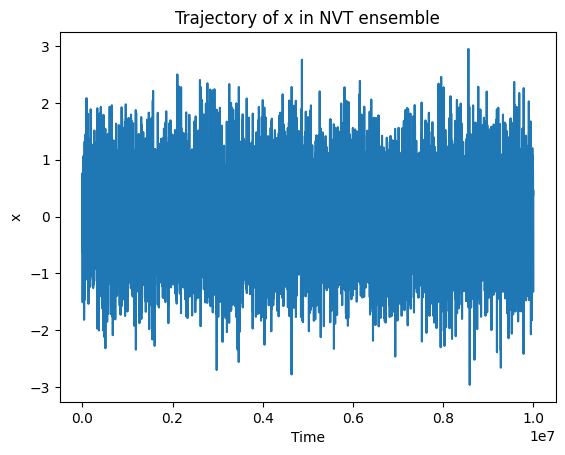

In [66]:
from tqdm.notebook import tqdm
# sample, but doing very simple molecular dynamics in NVT ensemble
def simple_nvt(x, dt, n_steps, gamma=1.0, kT=1.0, gradient_fn=parabolic_gradient):
    n_steps = int(n_steps)
    traj_x = []
    # Initialize velocity randomly from Maxwell-Boltzmann distribution
    v = np.random.normal(0, np.sqrt(kT))
    
    for n in tqdm(range(n_steps), total=n_steps):
        # calculate the force
        f = -gradient_fn(x, 1, 0, 0)
        
        # First half of velocity update
        v = v + (f * dt - gamma * v * dt) / 2
        
        # Add random force from Langevin thermostat
        noise = np.sqrt(2 * gamma * kT * dt) * np.random.normal(0, 1)
        v = v + noise / 2
        
        # Position update
        x = x + v * dt
        
        # Second half of updates
        f = -gradient_fn(x, 1, 0, 0)
        v = v + (f * dt - gamma * v * dt) / 2
        v = v + noise / 2
        
        traj_x.append(x)
        
    return x, np.array(traj_x)

kbT = 1.0

x, traj_x = simple_nvt(0, 0.001, 1e7, kT=kbT)
plt.plot(traj_x)
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Trajectory of x in NVT ensemble')
plt.show()

  0%|          | 0/10000000 [00:00<?, ?it/s]

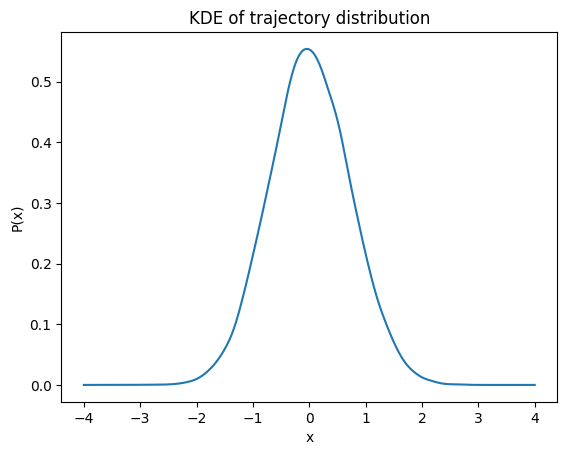

In [40]:
# do kernel density estimation on the trajectory using Gaussian kernels
# define grid points for evaluation
x_grid = np.linspace(-4, 4, 200)

# use bandwidth of 0.1 for the Gaussian kernels
h = 0.1

# initialize density estimate
density = np.zeros_like(x_grid)

# loop over all trajectory points and add their kernel contributions
for x_i in tqdm(traj_x, total=len(traj_x)):
    # evaluate Gaussian kernel centered at x_i for all grid points
    kernel = np.exp(-0.5 * ((x_grid - x_i)/h)**2) / (np.sqrt(2*np.pi))
    density += kernel

# normalize by number of points and width of the kernels
density /= h
density /= len(traj_x)


# plot the density estimate
plt.plot(x_grid, density)
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('KDE of trajectory distribution')
plt.show()


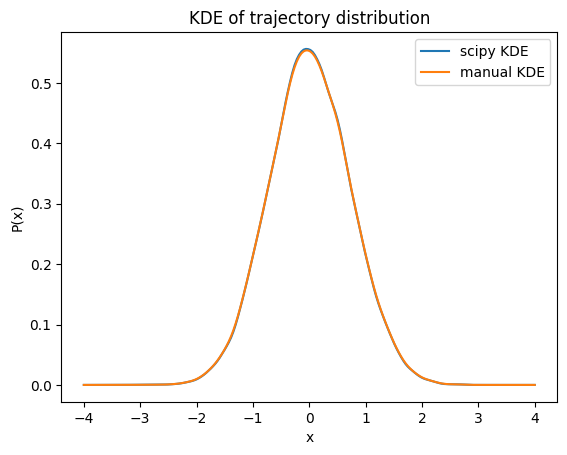

In [41]:
# kernel density estimation with scipy
# this is about 4x faster
from scipy.stats import gaussian_kde
kde = gaussian_kde(traj_x, bw_method=0.1)
plt.plot(x_grid, kde(x_grid), label='scipy KDE')
plt.plot(x_grid, density, label='manual KDE')
plt.legend()
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('KDE of trajectory distribution')
plt.show()

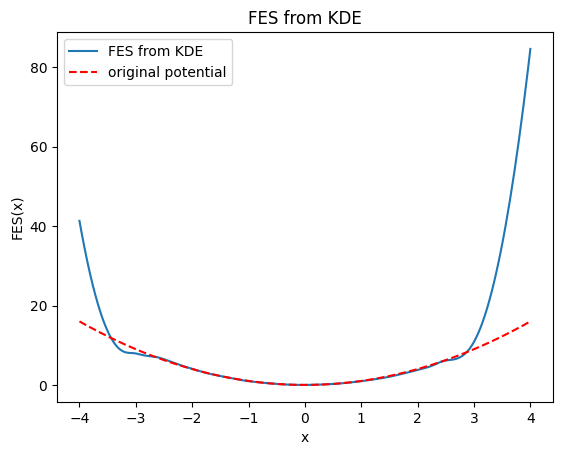

In [47]:
# turn probability distribution into the FES
fes = -kbT * np.log(density)
# shift to have minimum at 0
fes -= np.min(fes)
plt.plot(x_grid, fes, label='FES from KDE')
plt.plot(x_grid, parabolic_potential(x_grid, 1, 0, 0), 'r--', label='original potential')
plt.legend()
plt.xlabel('x')
plt.ylabel('FES(x)')
plt.title('FES from KDE')
plt.show()


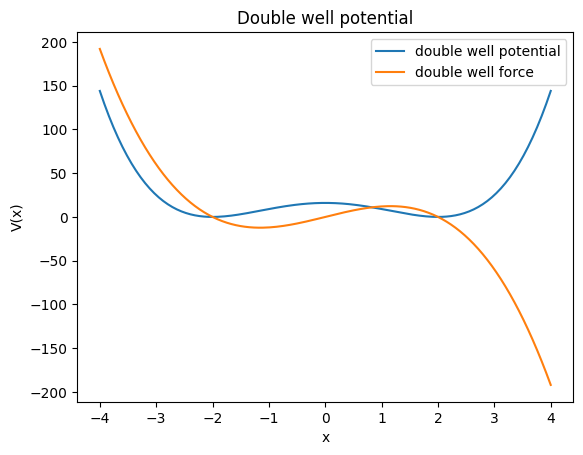

In [63]:
# bias the distribution with a double well potential
# minima at x = -2 and x = 2

a = 1.0  # controls barrier height
b = 2.0  # sets location of minima
    
def bias_potential(x):
    # double well potential with minima at x = ±2
    # V(x) = a*(x^2 - b^2)^2 where b=2 sets location of minima
    # a controls barrier height
    return a * (x**2 - b**2)**2

def bias_gradient(x):
    return 4 * a * x * (x**2 - b**2)

plt.plot(x_grid, bias_potential(x_grid), label='double well potential')
plt.plot(x_grid, -bias_gradient(x_grid), label='double well force')
plt.legend()
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Double well potential')
plt.show()

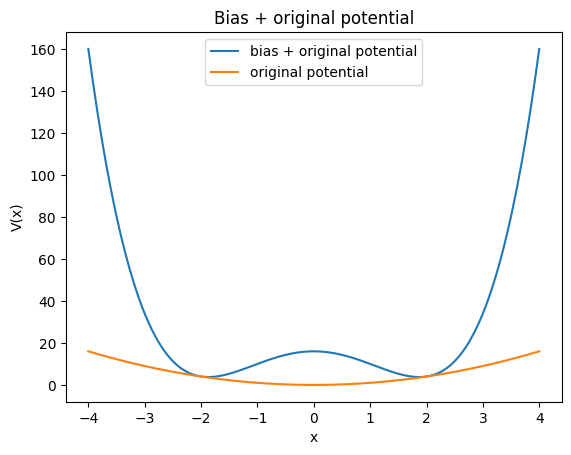

In [64]:
x_grid = np.linspace(-4, 4, 200)
# plot the bias + original potential
plt.plot(x_grid, bias_potential(x_grid) + parabolic_potential(x_grid, 1, 0, 0), label='bias + original potential')
plt.plot(x_grid, parabolic_potential(x_grid, 1, 0, 0), label='original potential')
plt.legend()
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Bias + original potential')
plt.show()

  0%|          | 0/10000000 [00:00<?, ?it/s]

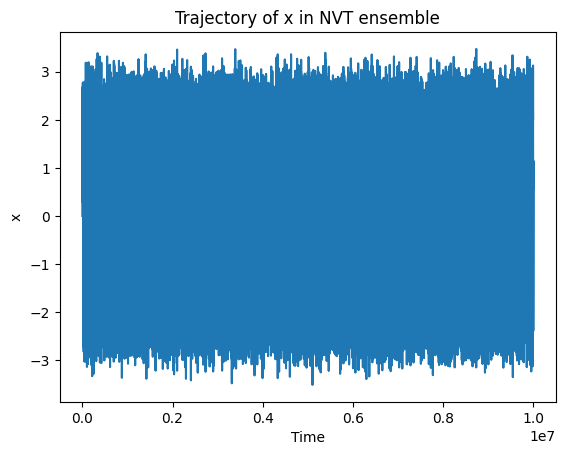

In [68]:
# sample from the biased distribution with simple NVT

def bias_plus_original_potential(x, a, b, c):
    return bias_potential(x) + parabolic_potential(x, a, b, c)

def bias_plus_original_gradient(x, a, b, c):
    return bias_gradient(x) + parabolic_gradient(x, a, b, c)

kbT = 10.0

x, traj_x = simple_nvt(0, 0.001, 1e7, kT=kbT, gradient_fn=bias_plus_original_gradient)
plt.plot(traj_x)
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Trajectory of x in NVT ensemble')
plt.show()

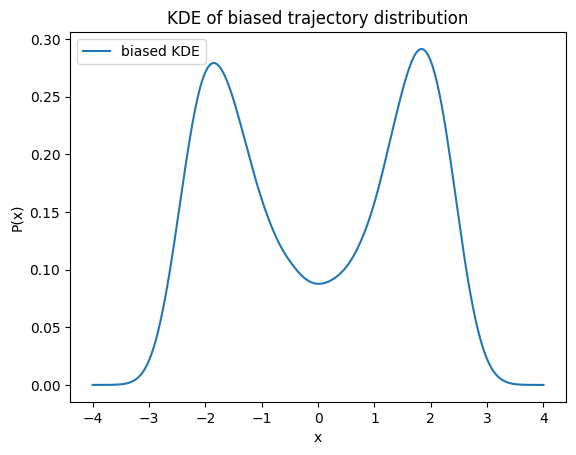

In [69]:
from scipy.stats import gaussian_kde
kde_biased = gaussian_kde(traj_x, bw_method=0.1)
plt.plot(x_grid, kde_biased(x_grid), label='biased KDE')
plt.legend()
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('KDE of biased trajectory distribution')
plt.show()

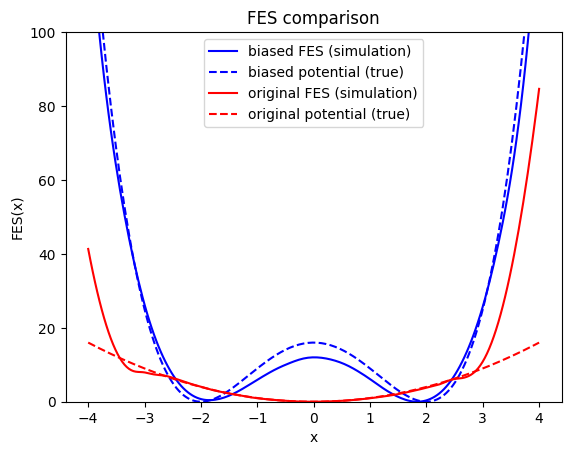

In [72]:
# turn the biased KDE into the FES
fes_biased = -kbT * np.log(kde_biased(x_grid))
fes_biased -= np.min(fes_biased)
plt.plot(x_grid, fes_biased, 'b', label='biased FES (simulation)')
plt.plot(x_grid, bias_potential(x_grid), 'b--', label='biased potential (true)')
plt.plot(x_grid, fes, 'r', label='original FES (simulation)')
plt.plot(x_grid, parabolic_potential(x_grid, 1, 0, 0), 'r--', label='original potential (true)')
plt.legend()
plt.ylim(0, 100)
plt.xlabel('x')
plt.ylabel('FES(x)')
plt.title('FES comparison')
plt.show()

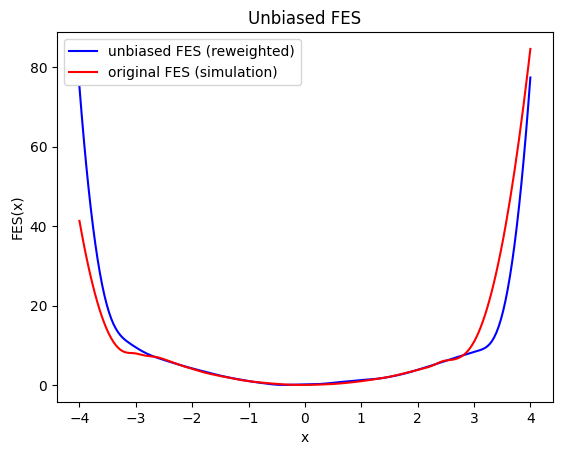

In [76]:
# reweight the biased distribution
weights = np.exp(bias_potential(traj_x) / kbT)

weighted_kde = gaussian_kde(traj_x, weights=weights, bw_method=0.1)
fes_unbiased = -kbT * np.log(weighted_kde(x_grid))
fes_unbiased -= np.min(fes_unbiased)
plt.plot(x_grid, fes_unbiased, 'b', label='unbiased FES (reweighted)')
plt.plot(x_grid, fes, 'r', label='original FES (simulation)')
plt.legend()
plt.xlabel('x')
plt.ylabel('FES(x)')
plt.title('Unbiased FES')
plt.show()



In [78]:
import h5py
import numpy as np

# Example data
x_bins = np.linspace(-5, 5, 100)  # x grid values
y_bins = np.linspace(-5, 5, 100)  # y grid values
energy_function = np.random.random((100, 100))  # Replace with actual energy data

# Save to HDF5
with h5py.File('fes_2d.h5', 'w') as f:
    f.create_dataset('x_bins', data=x_bins)
    f.create_dataset('y_bins', data=y_bins)
    f.create_dataset('energy_function', data=energy_function)
    f.attrs['description'] = '2D Free Energy Surface'
    f.attrs['units'] = 'kJ/mol'

In [79]:
# open the file and read the data
with h5py.File('fes_2d.h5', 'r') as f:
    x_bins = f['x_bins'][:]
    y_bins = f['y_bins'][:]
    energy_function = f['energy_function'][:]
    print(x_bins)
    print(y_bins)
    print(energy_function)

[-5.         -4.8989899  -4.7979798  -4.6969697  -4.5959596  -4.49494949
 -4.39393939 -4.29292929 -4.19191919 -4.09090909 -3.98989899 -3.88888889
 -3.78787879 -3.68686869 -3.58585859 -3.48484848 -3.38383838 -3.28282828
 -3.18181818 -3.08080808 -2.97979798 -2.87878788 -2.77777778 -2.67676768
 -2.57575758 -2.47474747 -2.37373737 -2.27272727 -2.17171717 -2.07070707
 -1.96969697 -1.86868687 -1.76767677 -1.66666667 -1.56565657 -1.46464646
 -1.36363636 -1.26262626 -1.16161616 -1.06060606 -0.95959596 -0.85858586
 -0.75757576 -0.65656566 -0.55555556 -0.45454545 -0.35353535 -0.25252525
 -0.15151515 -0.05050505  0.05050505  0.15151515  0.25252525  0.35353535
  0.45454545  0.55555556  0.65656566  0.75757576  0.85858586  0.95959596
  1.06060606  1.16161616  1.26262626  1.36363636  1.46464646  1.56565657
  1.66666667  1.76767677  1.86868687  1.96969697  2.07070707  2.17171717
  2.27272727  2.37373737  2.47474747  2.57575758  2.67676768  2.77777778
  2.87878788  2.97979798  3.08080808  3.18181818  3